In [1]:
# 필요한 import문
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

# super-resolution
# PyTorch에서 구현된 초해상도 모델
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# 위에서 정의된 모델을 사용하여 초해상도 모델 생성
torch_model = SuperResolutionNet(upscale_factor=3)

In [2]:
# 미리 학습된 가중치를 읽어옵니다
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # 임의의 수

# 모델을 미리 학습된 가중치로 초기화합니다
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# 모델을 추론 모드로 전환합니다
torch_model.eval()

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

이제 tracing이나 스크립팅을 통해서 모델을 변환할수있다.
이 튜토리얼에서는 tracing을 통해 변환된 모델을 사용함.

모델을 변환하기 위해서 torch.onnx.export()함수를 호출한다. 이 함수는 모델을 실행하면 어떤 연산자들이 출력값을 계산하는데 사용되었는지를 기록한다.

export함수가 직접 모델을 실행하기 때문에, 우리가 직접 입력 텐서를 넣어줘야한다. 이텐서의 값은 알맞은 자료형과 모양이라면 랜덤하게 결정되어도 무방하다. 특정차원을 동적차원으로 지정하지않는이상, onnx로 변환된 그래프의 경우 입력값의 크기는 모든 차원에 대해 고정된다.

예시에서는 배치사이즈 1을 사용해서 변환했지만, torch.onnx.export() dynamics_axes 인자의 첫번째 차원은 동적차원으로 지정한다. 따라서 변환된 모델은 임의의 배치사이즈에 대해 [batchsize,1,224,224]사이즈를 입력값을 받을 수 있다.

In [3]:
# 모델에 대한 입력값
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# 모델 변환
torch.onnx.export(torch_model,               # 실행될 모델
                  x,                         # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "model.onnx",   # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                  opset_version=10,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적화시 상수폴딩을 사용할지의 여부
                  input_names = ['input'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output'], # 모델의 출력값을 가리키는 이름
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
                                'output' : {0 : 'batch_size'}})

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [7]:
!ls -alh model.onnx

-rw-r--r--@ 1 juniverse  staff   235K Aug 22 15:36 model.onnx


In [8]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

In [56]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX 런타임에서 계산된 결과값
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX 런타임과 PyTorch에서 연산된 결과값 비교
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [58]:
from PIL import Image
import torchvision.transforms as transforms
import requests
from io import BytesIO
url = 'https://tutorials.pytorch.kr/_images/cat_224x224.jpg'

res = requests.get(url)
img_bytes = res.content

img = Image.open(BytesIO(img_bytes))

print(type(img))

resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0).shape

<class 'PIL.JpegImagePlugin.JpegImageFile'>


torch.Size([1, 1, 224, 224])

In [68]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]
img_out_y.shape

(1, 1, 672, 672)

In [70]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# PyTorch 버전의 후처리 과정 코드를 이용해 결과 이미지 만들기
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")



/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_1739/33835651.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_cb.resize(img_out_y.size, Image.BICUBIC),
/var/folders/j9/psjfyfss16v_xrrj6mh5sw0h0000gn/T/ipykernel_1739/33835651.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_cr.resize(img_out_y.size, Image.BICUBIC),


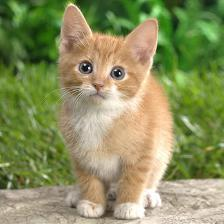

In [74]:
img

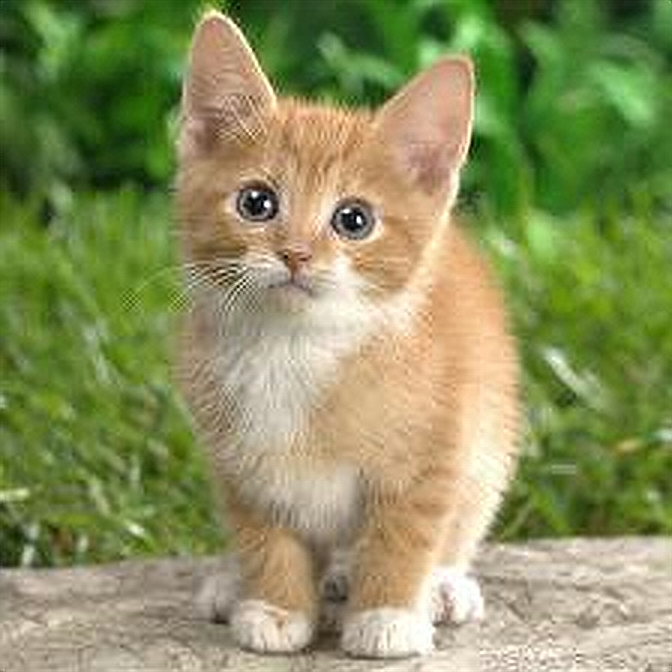

In [72]:
final_img